Data Source:

De Cock, D. (2011). Ames, Iowa: Alternative to the Boston Housing Data as an End of Semester Regression Project. Journal of Statistics Education, 19(3). https://doi.org/10.1080/10691898.2011.11889627

In [1]:
from pyreal.sample_applications import ames_housing

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In this tutorial, we use Pyreal to get feature contribution explanations for the AmesHousing dataset

First, we load in the data. Pyreal expects all data as DataFrames, where columns have the feature names.

In [2]:
x_orig, y = ames_housing.load_data(include_targets=True)
sample_houses = ames_housing.load_sample_houses()

Next, we load in the interpretable feature descriptions.

In [3]:
feature_descriptions = ames_housing.load_feature_descriptions()
feature_descriptions

{'MSSubClass': 'Identifies the type of dwelling involved in the sale.',
 'MSZoning': 'Identifies the general zoning classification of the sale.',
 'LotFrontage': 'Linear feet of street connected to property',
 'LotArea': 'Lot size in square feet',
 'Street': 'Type of road access to property',
 'Alley': 'Type of alley access to property',
 'LotShape': 'General shape of property',
 'LandContour': 'Flatness of the property',
 'Utilities': 'Type of utilities available',
 'LotConfig': 'Lot configuration',
 'LandSlope': 'Slope of property',
 'Neighborhood': 'Physical locations within Ames city limits',
 'Condition1': 'Proximity to various conditions',
 'Condition2': 'Proximity to various conditions (if more than one is present)',
 'BldgType': 'Type of dwelling',
 'HouseStyle': 'Style of dwelling',
 'OverallQual': 'Rates the overall material and finish of the house',
 'OverallCond': 'Rates the overall condition of the house',
 'YearBuilt': 'Original construction date',
 'YearRemodAdd': 'Remod

Next, we load the transfomers.

The first kind of transformer manually imputes the data based on information we know about the dataset.
We will call this the `AmesHousingImputer`

This imputation code comes from https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

In [4]:
transformers = ames_housing.load_transformers()
transformers

In [5]:
model = ames_housing.load_model()
model

Ridge()

Now, we can initialize a RealApp object.

In [6]:
from pyreal import RealApp

realApp =  RealApp(model,
                   X_train_orig=x_orig,
                   y_train=y,
                   transformers=transformers,
                   feature_descriptions=feature_descriptions,
                   id_column="Address"
                )

We can make predictions using RealApp objects.

In [7]:
realApp.predict(sample_houses)

{'312 Oakway Lane': 157609.44775291224,
 '3699 Jenna Lane': 208022.03968356707,
 '3880 Hazelwood Avenue': 205414.61830773746,
 '842 Jenna Lane': 208627.01812434796,
 '1580 Cameron Road': 172556.736624001,
 '2231 Hillhaven Drive': 288442.944861619,
 '215 Green Acres Road': 165163.16885054362,
 '2119 Edsel Road': 276234.6844264523,
 '642 Fulton Street': 232024.4787578403}

And generate different types of explanations

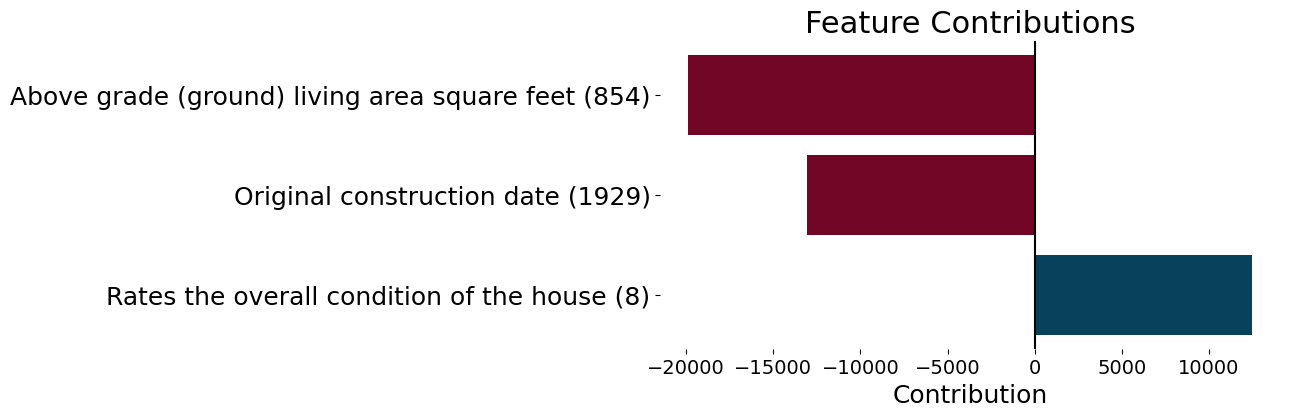

In [8]:
from pyreal.visualize import feature_bar_plot

conts = realApp.produce_feature_contributions(x_orig[0:10])

feature_bar_plot(conts[7], num_features=3, filename="ames_plot_sample.png")

In [9]:
realApp.produce_similar_examples(sample_houses.iloc[0], num_examples=2, fast=True)

{'X':      Identifies the type of dwelling involved in the sale.  \
 193                                                 20       
 553                                                 20       
 
     Identifies the general zoning classification of the sale.  \
 193                                                 RL          
 553                                                 RL          
 
      Linear feet of street connected to property  Lot size in square feet  \
 193                                         75.0                    10125   
 553                                         77.0                    10010   
 
     Type of road access to property Type of alley access to property  \
 193                            Pave                              NaN   
 553                            Pave                              NaN   
 
     General shape of property Flatness of the property  \
 193                       Reg                      Lvl   
 553                       Re

In [10]:
realApp.produce_feature_importance()

,Feature Name,Importance
0,Identifies the type of dwelling involved in th...,1832.089511
1,Linear feet of street connected to property,398.421951
2,Lot size in square feet,2677.824922
3,Rates the overall material and finish of the h...,7380.844318
4,Rates the overall condition of the house,4659.680705
...,...,...
74,Type of roof,3468.916708
75,Condition of sale,2303.651844
76,Type of sale,4731.598515
77,Type of road access to property,128.283698
